### **Exploring Climate Effects on Mental Health Using Supervised Machine Learning and Explainable AI**
We used a **supervised machine learning** approach to identify mental health cases associated with climate variables—**specific humidity (q)**, **temperature (t2m)**, and **UV radiation (uvbed)**. Using explainable AI techniques, we identified threshold values where these variables most strongly influenced the model’s predictions of mental health events.

> **Disclaimer:** Many mental health conditions are influenced by factors beyond climate, including genetics, lifestyle, socio-economic status, and access to healthcare. In this analysis, we focused exclusively on climatic variables (q, t2m, uvbed) to explore their potential impact on different mental health categories as an initial investigation.


In [1]:
# %config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.cluster import KMeans
# from sklearn.cluster import SpectralClustering
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# from imblearn.under_sampling import RandomUnderSampler
# import xgboost as xgb

# 
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde

# import warnings
# from sklearn.exceptions import ConvergenceWarning
# Suppress specific warning
# warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

### **1. Data Loading and Preprocessing**
We used ambulance data provided by East Midlands Ambulance Service (EMAS), UK, for this analysis. However, in accordance with our data sharing agreement with EMAS, we are unable to publicly share this dataset. It is important to note that this data represents only one perspective on mental health-related incidents, as it reflects cases reported through ambulance services. In future work, we aim to incorporate additional data sources, including the Integrated Care Board (ICB) dataset for Lincolnshire, which offers a broader and more comprehensive view than the EMAS dataset.

#### Read Data

In [2]:
#### read the climate_health data
df = pd.read_csv(
    "dataset/health_climate_2018_2020.csv", 
    parse_dates=["incident_time"]
)

#### Compute temporal features

In [3]:
# compute temporal features based on incident_time
# Seasonality = patterns that repeat over a known cycle, usually time-based. For climate
def get_days_in_year(year):
    return 366 if calendar.isleap(year) else 365
        
def temporal_cyclical_features(df, time_col='incident_time'):
    df = df.copy()

    # Convert the time column to datetime if not already
    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col])

    # Extract temporal features
    df['DayOfYear'] = df[time_col].dt.dayofyear                 # Day of the year (1-365/366)
    df['Month'] = df[time_col].dt.month                         # Month of the year (1-12)
    df['WeekOfYear'] = df[time_col].dt.isocalendar().week
    df['WeekOfYear'] = df['WeekOfYear'].apply(lambda x: x if x <= 52 else 52)  # Handle Week 53 cases by mapping them to 52
 
    # Determine the season (0: Winter, 1: Spring, 2: Summer, 3: Fall)
    df['Season'] = df[time_col].apply(lambda x: 
        0 if x.month in [12, 1, 2] else 
        1 if x.month in [3, 4, 5] else 
        2 if x.month in [6, 7, 8] else 
        3
    )
    return df


df = temporal_cyclical_features(df, time_col='incident_time')

#### Select Required Season
Only the spring and summer seasons were included in this analysis, as they are assumed to represent warmer periods of the year. During the computation of temporal features, spring and summer months were assigned season values of 1 and 2, respectively.

In [4]:
df = df[df['Season'].isin([1, 2])] # 1 and 2 = spring and summer 

#### Filter Dataset by Mental Health
The EMAS dataset includes a variety of clinical categories, but for this study, we focus on mental health-related cases, which will be extracted from the dataset.

In [5]:
mh_df = df[df['clinical_category'] == '(Mental Health)'].copy()

#### Drop NANs
Most ML algorithms cannot handle NaNs directly, so we must remove them

In [6]:
mh_df = mh_df.dropna() #Drop Nans

####  Metrics Conversion
Temperature is converted from Kelvin (K) to Celsius (°C) because Celsius is more widely understood and relevant for everyday use. Humidity is converted from kg/kg to g/kg for easier interpretation, as g/kg is a more familiar and practical unit for describing moisture in the air.

In [7]:
mh_df['t2m_c'] = mh_df['t2m'] - 273.15

In [8]:
# Specific humidity in g/kg
mh_df['q_g_kg'] = mh_df['q'] * 1000

#### ONLY Hot Days (Temp > 15°C)
We assume hot days from March to August should have temperatures above 15°C.

In [9]:
# Filter out temperatures below 15°C
mh_df = mh_df[mh_df['t2m_c'] >= 15].copy()

### **One-vs-Rest Classifier**
- This code trains one classifier per mental health category using a One-vs-Rest strategy.
- It performs data cleaning,
- oversamples the minority class using SMOTE,
- splits the data into training and testing sets,
- trains a XGBClassifier on each category, and
- stores the models and test data for future predictions.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from xgboost import XGBClassifier

# Categories and features
categories = [
    'Anxiety (Mental Health)',
    'Intentional Drug Overdose (Mental Health)',
    'Depression (Mental Health)',
    'Attempted Suicide (Mental Health)',
    'Acute Behavioural Disturbance (Mental Health)',
    'Dementia (Mental Health)',
    'Transport Under Mental Health Act (Mental Health)',
    'Psychosis (Mental Health)'    
]

climate_features = ['q_g_kg', 't2m_c', 'uvbed']
output_col = 'primary_clinical_impression'

models = {}
test_data = {}

# --------------------
# TRAINING LOOP
# --------------------
for category in tqdm(categories, desc="Training One-vs-Rest Models"):
    df_clean = mh_df[
        mh_df[output_col].isin(categories)
    ][climate_features + [output_col]].dropna()

    # Binary target: 1 if current category, else 0
    df_clean['target'] = df_clean[output_col].apply(lambda x: 1 if x == category else 0)

    X = df_clean[climate_features]
    y = df_clean['target']

    # Oversample minority class with SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42
    )

    # XGBoost binary classifier
    model = XGBClassifier(
        n_estimators=100,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)

    # Store model and test set for later use
    models[category] = model
    test_data[category] = (X_test, y_test)


Training One-vs-Rest Models: 100%|███████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.23it/s]


### Evaluation of the One-vs-Rest Models

In [11]:
# ----------------------------------
# EVALUATION 
# -----------------------------------
results = {}
for category in categories:
    print(f"\n[Evaluation] One-vs-Rest: {category}")

    model = models[category]
    X_test, y_test = test_data[category]
    y_pred = model.predict(X_test)

    # Store predictions and metrics
    results[category] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'feature_importances': model.feature_importances_,
        'X_test': X_test  # Add this line
    }


    # Evaluation output
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))



[Evaluation] One-vs-Rest: Anxiety (Mental Health)
Accuracy: 0.5445962732919255
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      4000
           1       0.55      0.53      0.54      4050

    accuracy                           0.54      8050
   macro avg       0.54      0.54      0.54      8050
weighted avg       0.54      0.54      0.54      8050


[Evaluation] One-vs-Rest: Intentional Drug Overdose (Mental Health)
Accuracy: 0.6284788410217308
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      5284
           1       0.62      0.65      0.63      5208

    accuracy                           0.63     10492
   macro avg       0.63      0.63      0.63     10492
weighted avg       0.63      0.63      0.63     10492


[Evaluation] One-vs-Rest: Depression (Mental Health)
Accuracy: 0.6596454274179393
Classification Report:
              pr

### Feature Importance
***SHAP vs. XGBoost:*** We used SHAP because it provides consistent, fair, and interpretable feature importance across all models, offering both global and local explanations for how each feature influences individual predictions

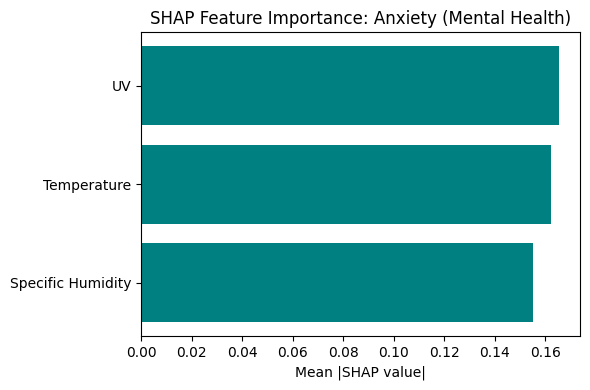

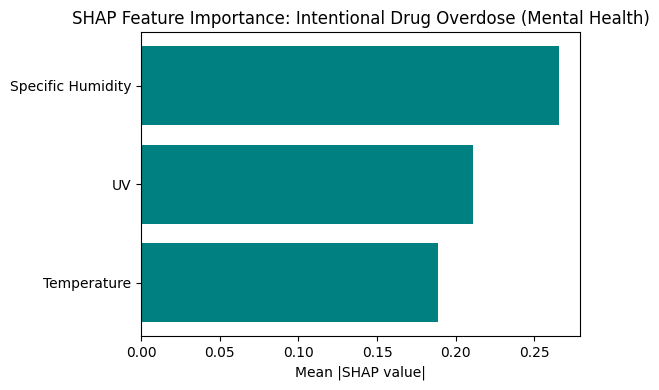

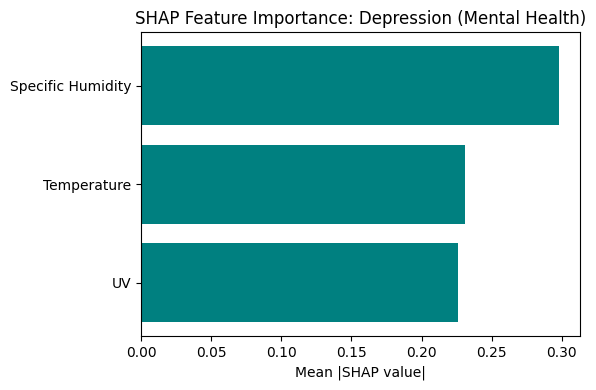

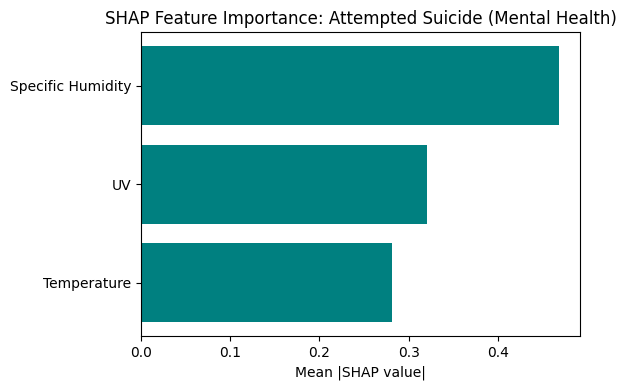

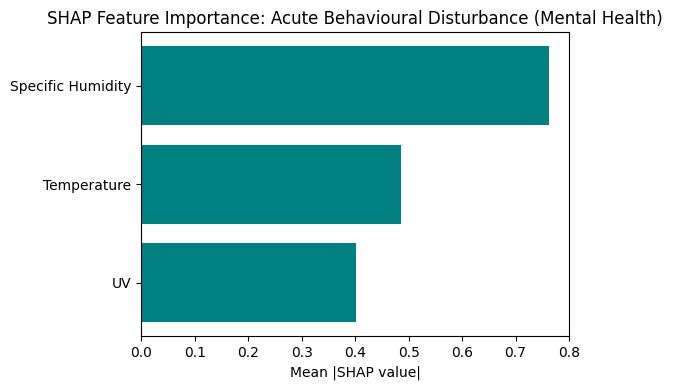

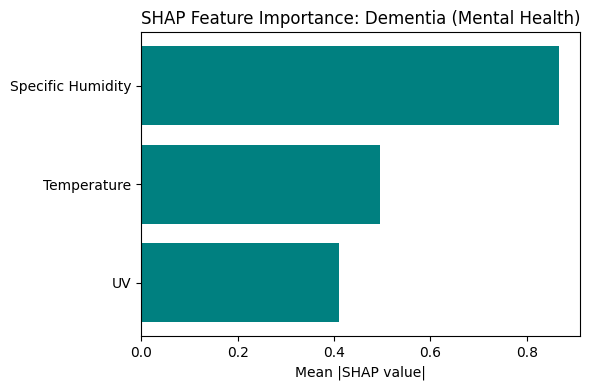

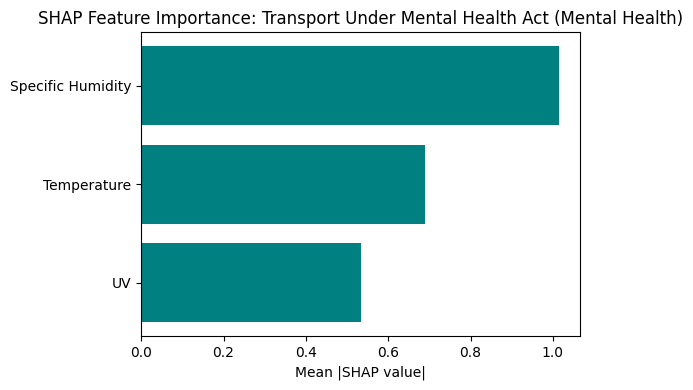

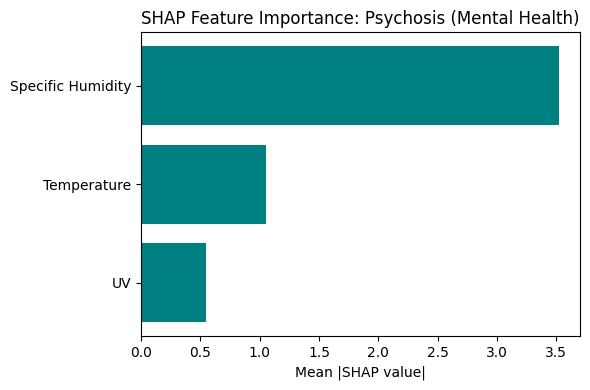

In [12]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mapping for renaming features
feature_name_map = {
    'q_g_kg': 'Specific Humidity',
    't2m_c': 'Temperature',
    'uvbed': 'UV',
    'uvbedcs': 'Clear-Sky UV'
}

shap_importance = {}

for category in categories:
    model = models[category]
    X_test, y_test = test_data[category]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Use shap_values[1] for binary classification
    shap_vals = shap_values if isinstance(shap_values, np.ndarray) else shap_values[1]

    # Calculate mean absolute SHAP values
    feature_importance = np.abs(shap_vals).mean(axis=0)

    # Rename features for display
    renamed_features = [feature_name_map.get(feat, feat) for feat in X_test.columns]

    importance_df = pd.DataFrame({
        'Feature': renamed_features,
        'Mean SHAP Value': feature_importance
    }).sort_values(by='Mean SHAP Value', ascending=True)

    shap_importance[category] = importance_df

    # Plot
    plt.figure(figsize=(6, 4))
    plt.barh(importance_df['Feature'], importance_df['Mean SHAP Value'], color='teal')
    plt.title(f"SHAP Feature Importance: {category}")
    plt.xlabel("Mean |SHAP value|")
    plt.tight_layout()
    plt.show()


### Finding Climate Threshold using SHAP Explainability
- Compute SHAP value thresholds for each feature and category.
- For the top 5% most impactful SHAP values, extract corresponding input ranges.
- Store min, max, mean feature values and mean SHAP for summary analysis.

> Note: The 95th percentile helps us select the top 5% of the most impactful SHAP values.This allows us to focus on the extreme cases where a feature has a strong influence on the model's predictions. By using this threshold, we can highlight the most significant features or observations in the explainability process, which is crucial for understanding how our model is making its predictions and which factors are driving them.


In [13]:
import numpy as np
import shap
import pandas as pd

# Store thresholds in a list for DataFrame
results = []

for category in categories:
    model = models[category]
    X_test, _ = test_data[category]

    # SHAP explainer and values
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)

    # Process each feature in the category
    for i, feature in enumerate(climate_features):
        feature_shap = np.abs(shap_values.values[:, i])
        shap_threshold = np.percentile(feature_shap, 95)

        # Boolean mask of high-impact SHAP values
        high_impact_mask = feature_shap >= shap_threshold
        high_impact_values = X_test.iloc[high_impact_mask][feature]

        if high_impact_values.empty:
            continue  # Skip if no values meet threshold

        # Store results in the list
        results.append({
            'Category': category,
            'Feature': feature,
            'Min Value': high_impact_values.min(),
            'Max Value': high_impact_values.max(),
            'Mean Value': high_impact_values.mean(),
            'SHAP Mean': feature_shap[high_impact_mask].mean()
        })

# Convert to DataFrame
df_summary = pd.DataFrame(results)

 97%|=================== | 13180/13545 [00:20<00:00]       

In [14]:
df_summary

,Category,Feature,Min Value,Max Value,Mean Value,SHAP Mean
0,Anxiety (Mental Health),q_g_kg,3.724698,13.081315,8.691931,0.639314
1,Anxiety (Mental Health),t2m_c,15.047021,31.137354,22.387406,0.642069
2,Anxiety (Mental Health),uvbed,0.008214,0.199968,0.104226,0.584975
3,Intentional Drug Overdose (Mental Health),q_g_kg,3.724758,12.867977,8.602534,1.351720
4,Intentional Drug Overdose (Mental Health),t2m_c,15.001367,30.832426,19.854175,0.726247
5,Intentional Drug Overdose (Mental Health),uvbed,0.005441,0.199968,0.077176,0.950222
6,Depression (Mental Health),q_g_kg,4.023735,14.134498,9.338043,1.554660
7,Depression (Mental Health),t2m_c,15.005029,31.149316,19.719786,0.910583
8,Depression (Mental Health),uvbed,0.007815,0.198504,0.094193,1.057351
9,Attempted Suicide (Mental Health),q_g_kg,4.168991,13.610140,8.669323,2.392842


### Personalised Interpretation of Climate Threshold based on SHAP
Generate interpretation text and heatmap to explain how climate features (humidity, temperature, UV) influence model predictions for different mental health categories using SHAP mean values.


#### Categorise climate variable 
Categorise climate variable impact levels (humidity, temperature, UV) based on UK-relevant thresholds.


In [15]:
# Define standard bins used in the UK
def categorize_impact(min_value, max_value, feature):
    if 'q_g_kg' in feature:  # Humidity (g/kg)
        if max_value <= 5:
            return "low"
        elif max_value <= 10:
            return "moderate"
        elif max_value <= 15:
            return "high"
        else:
            return "very high"
    
    elif 't2m_c' in feature:  # Temperature (°C)
        if max_value <= 5:
            return "cold"
        elif max_value <= 15:
            return "cool"
        elif max_value <= 25:
            return "warm"
        elif max_value <= 35:
            return "hot"
        else:
            return "extreme"
    
    elif 'uvbed' in feature:  # UV Radiation (W·m⁻²)
        if max_value <= 0.03:
            return "low"
        elif max_value <= 0.1:
            return "moderate"
        elif max_value <= 0.3:
            return "high"
        else:
            return "very high"


#### Heatmap of SHAP Impact Values of Climate Features by Mental Health Category
- Rename features for readability,
- pivot SHAP values by category, and
- plot a heatmap of feature impacts.

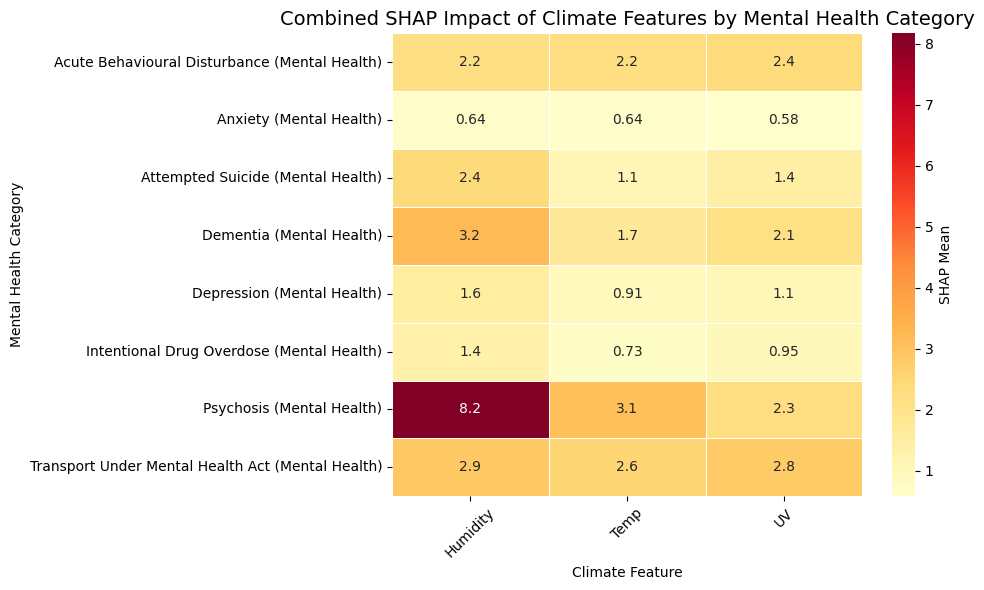

In [16]:
# Rename features for better readability
rename_map = {
    'q_g_kg': 'Humidity',
    't2m_c': 'Temp',
    'uvbed': 'UV'
}

# Pivot to get a matrix of SHAP Mean by Category and Feature
heatmap_data = df_summary.pivot(index="Category", columns="Feature", values="SHAP Mean")

# Sort features for consistent column order if needed
feature_order = ['q_g_kg', 't2m_c', 'uvbed']
heatmap_data = heatmap_data[feature_order]

# Rename columns for plotting
heatmap_data.rename(columns=rename_map, inplace=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'SHAP Mean'})
plt.title("Combined SHAP Impact of Climate Features by Mental Health Category", fontsize=14)
plt.xlabel("Climate Feature")
plt.ylabel("Mental Health Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Generate interpretation text
Generate interpretation text based on feature values and SHAP impact for each row, then display grouped interpretations by category.

In [17]:
# Generate interpretation text per row
def generate_interpretation(row):
    feature = row['Feature']
    min_val = row['Min Value']
    max_val = row['Max Value']
    mean_val = row['Mean Value']
    category = row['Category']
    
    label = categorize_impact(min_val, max_val, feature)
    
    if feature == 'q_g_kg':
        return (f"The mean humidity is {mean_val:.2f} g/kg ({label}), where SHAP was strongest. "
                f"However, humidity between ~{min_val:.2f}–{max_val:.2f} g/kg significantly pushes the model to predict {category}.")
    
    elif feature == 't2m_c':
        return (f"The mean temperature is {mean_val:.2f}°C ({label}), where SHAP was strongest. "
                f"However, temperature between ~{min_val:.2f}–{max_val:.2f}°C significantly pushes the model to predict {category}.")
    
    elif feature == 'uvbed':
        return (f"The mean UV radiation is {mean_val:.4f} W·m⁻² ({label}), where SHAP was strongest. "
                f"However, UV radiation between ~{min_val:.4f}–{max_val:.4f} W·m⁻² significantly pushes the model to predict {category}.")
    
    else:
        return ""

# Apply and group by Category
df_summary['Interpretation'] = df_summary.apply(generate_interpretation, axis=1)

# Display grouped interpretations
for category, group in df_summary.groupby("Category"):
    print(f"\n Category: {category}")
    for line in group['Interpretation']:
        print("•", line)



 Category: Acute Behavioural Disturbance (Mental Health)
• The mean humidity is 9.09 g/kg (high), where SHAP was strongest. However, humidity between ~3.73–14.12 g/kg significantly pushes the model to predict Acute Behavioural Disturbance (Mental Health).
• The mean temperature is 21.92°C (hot), where SHAP was strongest. However, temperature between ~15.00–29.59°C significantly pushes the model to predict Acute Behavioural Disturbance (Mental Health).
• The mean UV radiation is 0.0969 W·m⁻² (high), where SHAP was strongest. However, UV radiation between ~0.0054–0.1985 W·m⁻² significantly pushes the model to predict Acute Behavioural Disturbance (Mental Health).

 Category: Anxiety (Mental Health)
• The mean humidity is 8.69 g/kg (high), where SHAP was strongest. However, humidity between ~3.72–13.08 g/kg significantly pushes the model to predict Anxiety (Mental Health).
• The mean temperature is 22.39°C (hot), where SHAP was strongest. However, temperature between ~15.05–31.14°C signi

### Heatmap of Mean Climate Values by Mental Health Category
Plot side-by-side heatmaps of mean climate values by mental health category, with annotated bins and scaled colorbars


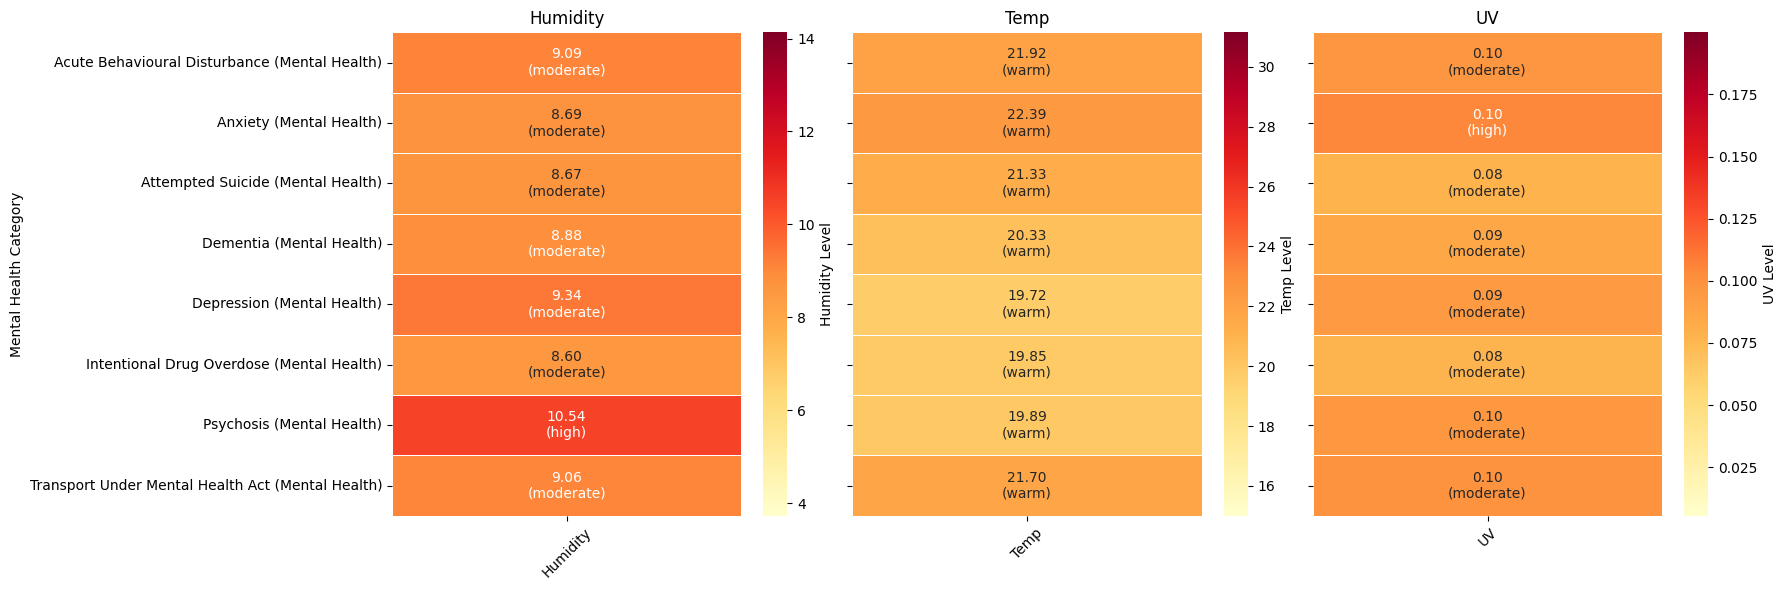

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Rename map and feature list
rename_map = {'q_g_kg': 'Humidity', 't2m_c': 'Temp', 'uvbed': 'UV'}
feature_order = ['q_g_kg', 't2m_c', 'uvbed']

# Compute min/max from original dataset
vmin_vmax = {
    feat: (mh_df[feat].min(), mh_df[feat].max())
    for feat in feature_order
}

# Prepare data matrix
pivot_cols = ['q_g_kg', 't2m_c', 'uvbed']
mean_data = df_summary.pivot(index="Category", columns="Feature", values="Mean Value")
mean_data = mean_data[pivot_cols]

# Add bin labels to each cell (e.g. "10.1 (moderate)")
annot_data = mean_data.copy().astype(str)
for row in annot_data.index:
    for col in annot_data.columns:
        val = mean_data.loc[row, col]
        bin_label = categorize_impact(val, val, col)
        annot_data.loc[row, col] = f"{val:.2f}\n({bin_label})"

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, feature in zip(axes, feature_order):
    sns.heatmap(
        mean_data[[feature]],
        annot=annot_data[[feature]],
        fmt="",
        cmap="YlOrRd",
        linewidths=0.5,
        vmin=vmin_vmax[feature][0],
        vmax=vmin_vmax[feature][1],
        cbar_kws={'label': f'{rename_map[feature]} Level'},
        ax=ax
    )
    ax.set_title(rename_map[feature])
    ax.set_xlabel("")
    ax.set_ylabel("Mental Health Category" if ax == axes[0] else "")
    ax.set_xticklabels([rename_map[feature]], rotation=45)

plt.tight_layout()
plt.show()
